<a href="https://colab.research.google.com/github/utopian18/ML_in_Textile/blob/main/ANN_predicts_Textile_Rejections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#loading the basic packages
import numpy as np
import pandas as pd

In [4]:
#this data is already cleaned and we will do some processing
df = pd.read_csv('textile_rejection_prediction.csv')

In [5]:
df.head()

,Sl,lot_no.,warp_count,weft_count,epi,ppi,remark,F.Ord.(Yds),Delivery,Req. Grey Qtv (Yds),Shrin%,Req. Beam L(yds),Recv. Beam L(Yds),Deliverd Yds,Rej.Yds,Total Prod Yds,Short/Ex. Yds,Total loss%
0,1,12207,40,40,110,80,double beam,31300,6.000360,33298,12.500542,38055.0928,38286.9360,34668,301.0,34969.0,1671.0,8.665974
1,2,12213,40,40,110,90,normal,54600,6.998927,58709,14.500689,68666.0504,69634.9800,59019,505.0,59524.0,815.0,14.519973
2,3,12313,40,40,110,90,normal,64715,6.999971,69586,14.499654,81386.8056,82556.9576,70613,341.0,70954.0,1368.0,14.054488
3,4,12315,40,40,110,90,normal,25500,6.998796,27419,14.502171,32069.8200,32353.0624,27820,0.0,27820.0,401.0,14.011231
4,5,12317,50,50,140,70,normal,20700,8.000000,22500,8.999734,24725.2024,24917.6760,22631,369.0,23000.0,500.0,7.696047


It seems the dataset has a lot of unnecessay columns, such as: lot no., required grey quantity, delivered yds, rejection yards and so on. we will make a list of some essential parameters and add some features by feature engineering

In [6]:
df.shape

(409, 18)

**Adding features**

In [7]:
dependent_vars = ['warp_count', 'weft_count', 'epi', 'ppi', 'remark', 'F.Ord.(Yds)', 'Delivery', 'Shrin%']
independent_var = ['Total loss%']

In [8]:
X = df[dependent_vars]
#rename some feature's name to make it more pythonic
X= X.rename(columns= {'Delivery': 'Allowance', 'remark':'beam_type', 'F.Ord.(Yds)':'Finish_order_yds', 'Shrin%': 'shrinkage' })
y = df[independent_var]

In [9]:
X.head()

,warp_count,weft_count,epi,ppi,beam_type,Finish_order_yds,Allowance,shrinkage
0,40,40,110,80,double beam,31300,6.000360,12.500542
1,40,40,110,90,normal,54600,6.998927,14.500689
2,40,40,110,90,normal,64715,6.999971,14.499654
3,40,40,110,90,normal,25500,6.998796,14.502171
4,50,50,140,70,normal,20700,8.000000,8.999734


Now we will add 2 features required grey fabrics and required beam length. the formulla for this is ${grey\space fabric \space required} = \frac {Req \space Finish \space Fabrics\times 100}{100 - warp\space allowance% ) }$

In [10]:
X['Grey_Fabric_yds']= (X['Finish_order_yds']*100)/(100-X['Allowance'])
X['Req_Beam_length_yds']= (X['Grey_Fabric_yds']*100)/(100-X['shrinkage'])

**Train Test split**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   warp_count           409 non-null    int64  
 1   weft_count           409 non-null    int64  
 2   epi                  409 non-null    int64  
 3   ppi                  409 non-null    int64  
 4   beam_type            409 non-null    object 
 5   Finish_order_yds     409 non-null    int64  
 6   Allowance            409 non-null    float64
 7   shrinkage            409 non-null    float64
 8   Grey_Fabric_yds      409 non-null    float64
 9   Req_Beam_length_yds  409 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 32.1+ KB


# For ANN one hot encoding is better. Hence, we will do one hot encoding for converting object to numerical values

only the beam_type is object here

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
ohe = OneHotEncoder(handle_unknown ='ignore')

In [16]:
ohe_beam_type = ohe.fit_transform(X_train[['beam_type']])
ohe_beam_type_test = ohe.transform(X_test[['beam_type']])
ohe_beam_type_train = pd.DataFrame(ohe_beam_type.toarray(), columns=['double_yran', 'double_beam', 'normal'] )
ohe_beam_type_test = pd.DataFrame(ohe_beam_type_test.toarray(), columns=['double_yran', 'double_beam', 'normal'] ) 
ohe_beam_type_train.index = X_train.index
ohe_beam_type_test.index = X_test.index

X_train= X_train.drop('beam_type', axis=1)
X_test = X_test.drop('beam_type', axis=1)

X_train = pd.concat([X_train, ohe_beam_type_train], axis=1)
X_test = pd.concat([X_test, ohe_beam_type_test], axis=1)

In [20]:
# X_train = ohe_transfrom_train(X_train)
# X_test = ohe_transfrom_test(X_test)

In [21]:
X_test.tail()

,warp_count,weft_count,epi,ppi,Finish_order_yds,Allowance,shrinkage,Grey_Fabric_yds,Req_Beam_length_yds,double_yran,double_beam,normal
68,40,40,110,70,18329,7.001877,9.997359,19709.0,21898.2464,0.0,0.0,1.0
20,40,40,110,90,33900,7.021393,14.529624,36460.0,42658.0552,0.0,0.0,1.0
153,30,30,110,80,1700,9.574468,15.730740,1880.0,2230.9440,0.0,0.0,1.0
14,40,40,110,90,28968,8.000127,13.571090,31487.0,36431.0968,0.0,0.0,1.0
398,40,40,110,90,1050,9.482759,16.544697,1160.0,1389.9656,0.0,0.0,1.0


For ANN scaling is a must

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
sc = MinMaxScaler()

Tensorflow works better with array rather than dataframe hence we convert the dataframe to array to scales them. Besides, we will use the array form to predict from our input data..

In [24]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Instead of Squential Model we prefer to use Functional api model**

In [26]:
from tensorflow.python.keras import activations
input_layer = keras.Input(shape=(X_test_sc.shape[1],))
dense_layer = layers.Dense(128,kernel_initializer='normal', activation='relu')
x = dense_layer(input_layer)
x = layers.Dense(256,kernel_initializer= 'normal' ,  activation='relu')(x) 
x = layers.Dense(128,kernel_initializer= 'normal' ,activation='relu')(x)
output_layer = layers.Dense(1,kernel_initializer= 'normal', activation='linear')(x)
model = keras.Model(inputs=input_layer, outputs=output_layer, name='Ann_model')
model.summary()

Model: "Ann_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='mae', optimizer='adam', metrics='mae')

**For early stopping**

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [30]:
history= model.fit(X_train_sc, y_train,epochs=600, validation_split=0.2, batch_size=20, callbacks=[early_stop], verbose=0)

In [31]:
from sklearn.metrics import r2_score

In [32]:
y_pred = model.predict(X_test_sc)
r2_score(y_test, y_pred)

0.44142542646879124

In [33]:
loss= history.history['loss']
val_loss= history.history['val_loss']


In [34]:
import matplotlib.pyplot as plt

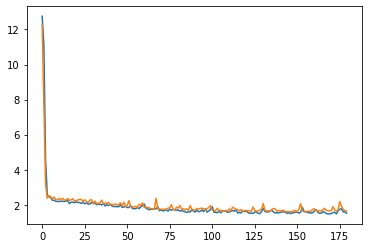

In [35]:
plt.plot(loss)
plt.plot(val_loss)

# **For a new value:**

In [36]:
epi = 100
ppi = 80
warp_count = 40
weft_count = 40
beam_type = 'normal'
# beam_type = ohe.transform(beam_type)
Finish_order_yds = 32000
Allowance=7
shrinkage = 12


In [37]:
new_df = pd.DataFrame({'warp_count':[warp_count],
              'weft_count':[weft_count],
              'epi':[epi],
              'ppi':[ppi],
              'beam_type':[beam_type],
              'Finish_order_yds':[Finish_order_yds],
              'Allowance':[Allowance] ,
              'shrinkage':[shrinkage] })

new_df['Grey_Fabric_yds'] = new_df['Finish_order_yds']*100/(100-new_df['Allowance'])
new_df['Req_Beam_length_yds'] = new_df['Grey_Fabric_yds']*100/(100- new_df['shrinkage'])
# Grey_Fabric_yds = Finish_order_yds*100/(100- Allowance)
# Req_Beam_length_yds = Grey_Fabric_yds*100/(100- shrinkage)

In [38]:
new_df

,warp_count,weft_count,epi,ppi,beam_type,Finish_order_yds,Allowance,shrinkage,Grey_Fabric_yds,Req_Beam_length_yds
0,40,40,100,80,normal,32000,7,12,34408.602151,39100.684262


In [40]:
def ohe_transfrom_test(X_test): 
  ohe_beam_type_test = ohe.transform(X_test[['beam_type']])
  ohe_beam_type_test = pd.DataFrame(ohe_beam_type_test.toarray(), columns=['double_yran', 'double_beam', 'normal'] ) 
  ohe_beam_type_test.index = X_test.index
  X_test = X_test.drop('beam_type', axis=1)
  X_test = pd.concat([X_test, ohe_beam_type_test], axis=1)
  return X_test

In [41]:
new_df= ohe_transfrom_test(new_df)

In [42]:
new_df_sc = sc.transform(new_df)

In [43]:
model.predict(new_df_sc)

array([[12.763369]], dtype=float32)